<a href="https://colab.research.google.com/github/andresf9824/TFM/blob/main/TFMipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Librerías

Comenzamos actualizando la librería FastAI. Al finalizar la instalación deberás reiniciar el kernel (menú Entorno de ejecución -> Reiniciar Entorno de ejecución).

In [1]:
!pip install fastai -Uq

Cargamos las librerias necesarias

In [5]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
import os
from pathlib import Path
import random

##Dataset

Para el desarrollo de este trabajo fin de máster, vamos a  trabajar con un dataset proporcionado por el personal del hospital. Este dataset dedicado a la segmentación de imágenes de bacterias, consta de dos carpetas principales: la carpeta “images” donde se encuentran las imágenes de las bacterias, que a su vez cuenta con 313 imagenes para el conjunto de test, y 1154 para el conjunto de train. Hemos particionado el dataset para que cada imagen de la carpeta images, tenga su correspondiente mascarara en la carpeta Labels. Entonces para esta practica el conjunto de train no tendra 1154 imagenes, sino 444.

Por otra parte, tenemos la carpeta de “label” donde se encuentran las máscaras correspondientes a las imágenes de la carpeta anteriormente mencionada.El conjunto de test cuenta con 313 elementos, el de train con 444.



In [7]:
nombre_del_archivo = 'Segmentacion.rar'
os.system(f'unrar x {nombre_del_archivo}')

0

Vamos a explorar el contenido de este dataset. Para ello vamos a crear un objeto Path que apunta al directorio que acabamos de crear.

In [10]:
path=Path('Segmentacion/')

Podemos ver el contenido de este directorio usando el comando ls().

In [11]:
path.ls()

(#3) [Path('Segmentacion/codes.txt'),Path('Segmentacion/Labels'),Path('Segmentacion/Images')]

Si exploráis el directorio podréis ver que hay dos carpetas llamadas Images y Labels. La carpeta Images contiene las imágenes del dataset, y la carpeta Labels contiene las en forma de máscara. Para cada imagen, hay un fichero de anotación siguiendo la siguiente nomenclatura: si la imagen se llama xxx.jpg, su fichero de anotación es xxx.png. El dataset está partido en entrenamiento y test como puede verse en las carpetas Images y Labels. Además, se proporcionan un fichero txt que van a contener las clases de los objetos que utilizaremos en esta práctica. El fichero codes.txt contiene solo dos clases (background y bacteria).

In [12]:
(path/'Images').ls()

(#2) [Path('Segmentacion/Images/train'),Path('Segmentacion/Images/test')]

In [13]:
(path/'Images/train').ls()

(#444) [Path('Segmentacion/Images/train/G237c-0.3.jpg'),Path('Segmentacion/Images/train/G75a-0.5.jpg'),Path('Segmentacion/Images/train/G275a-0.3 (2).jpg'),Path('Segmentacion/Images/train/G131a-0.5.jpg'),Path('Segmentacion/Images/train/G110a-0.3 (2).jpg'),Path('Segmentacion/Images/train/G237c-0.5 (3).jpg'),Path('Segmentacion/Images/train/G62c 0.3 (2).jpg'),Path('Segmentacion/Images/train/G184b-0.5.jpg'),Path('Segmentacion/Images/train/G177 b 0.5.jpg'),Path('Segmentacion/Images/train/G60a 0.5.jpg')...]

In [14]:
(path/'Labels/train').ls()

(#444) [Path('Segmentacion/Labels/train/G206c-0.5.png'),Path('Segmentacion/Labels/train/G106a-0.3.png'),Path('Segmentacion/Labels/train/G201b 0.5 (2).png'),Path('Segmentacion/Labels/train/G275b 0.5.png'),Path('Segmentacion/Labels/train/G210a-0.3 (3).png'),Path('Segmentacion/Labels/train/G76c-0.3.png'),Path('Segmentacion/Labels/train/G22b-0.3.png'),Path('Segmentacion/Labels/train/G168 b 0.3.png'),Path('Segmentacion/Labels/train/G181c-0.3.png'),Path('Segmentacion/Labels/train/G147a 0.3.png')...]

En primer lugar vamos a definir los paths donde se van a encontrar nuestras imágenes y sus etiquetas.

In [15]:
path_images = path/"Images"
path_labels = path/"Labels"

A continuación definimos el nombre que va a tener nuestra carpeta de test.

In [16]:
test_name = "test"

Definimos una función que dado el path de una imagen nos devuelve el path de su anotación.

In [17]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

Cargamos las dos clases que pueden tener los píxeles de nuestra imágenes y lo almacenamos en una lista codes.

In [18]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [19]:
codes

array(['Background', 'Bacteria'], dtype='<U10')

Podemos ahora ver alguna de las imágenes de nuestro dataset.

<Axes: >

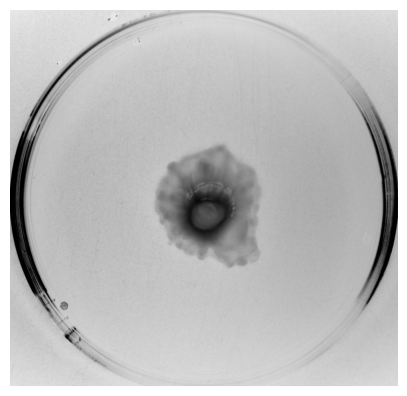

In [20]:
img_f = path_images/'train/G1b-0.5.jpg'
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

Y también la mascara asociada.

<Axes: >

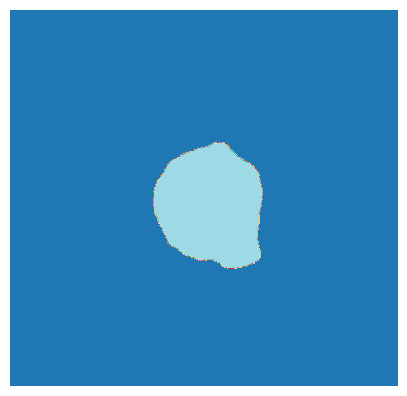

In [21]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

Como podemos ver en la imagen anterior tenemos una máscara donde cada tipo de objeto de nuestra imagen tiene un color distinto.

###Partición del dataset

Como en cualquier problema de machine learning debemos partir nuestro dataset en entrenamiento y test. En nuestro caso los datos ya están separados por lo que vamos a definir una función que nos permite diferenciarlos gracias a la estructura de carpetas que usamos.

In [22]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

###Data augmentation

Al igual que con los modelos definidos en prácticas anteriores podemos usar técnicas de aumento de datos, para lo que usaremos la librería Albumentations. Recordar que dichas transformaciones no deben aplicarse solo a la imagen sino también a su anotación. Para ello vamos a definir una clase que hereda de la clase ItemTransform y que nos va a permitir realizar transformaciones sobre pares (imagen,máscara).

La clase ItemTransform tiene un método encodes que es el encargado de realizar la transformación sobre su entrada x que en este caso será un par (imagen,máscara). Además el constructor de la clase que vamos a definir recibirá como parámetro las transformaciones a aplicar.

In [23]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    HorizontalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug):
        self.aug = aug

    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

En nuestro caso vamos a utilizar solo flips horizontales, rotaciones, y una operación que aplica una pequeña distorsión a la imagen. Dichas transformaciones se aplicarán de manera secuencial y de manera aleatoria.

In [24]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

Por último construimos un objeto de la clase definida anteriormente.

In [25]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

Con esta funcion binarizamos las mascaras. Todos los valores diferentes a 255 valdrán 0(background), y todos los valores iguales a 255 valdrán 1(Bacterias.).

In [26]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self):
        pass
    def encodes(self, x):
        img,mask = x

        #Convert to array
        mask = np.array(mask)

        mask[mask!=255]=0
        # Change 255 for 1
        mask[mask==255]=1


        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

##Dataloader

Ya estamos listos para definir nuestro DataBlock y seguidamente nuestro DataLoader. Nuestro DataBlock se define del siguiente modo.

In [159]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[RandomResizedCrop((1000,1000)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Vamos a explicar cada una de las componentes anteriores:



* blocks=(ImageBlock, MaskBlock(codes)). En este caso tenemos que la entrada de nuestro modelo va a ser una imagen (representada mediante un ImageBlock) y su salida es una máscara (representado mediante MaskBlock) cuyos posibles valores son aquellos proporcionados por la lista de clases almacenada en la variable codes.
* get_items=partial(get_image_files,folders=['train']). El parámetro get_items sirve para indicar cómo cargar los datos de nuestro dataset. Para esto vamos a usar la función get_image_files que devuelve los paths de las imágenes que se encuentran dentro de la carpeta folders (en nuestro caso la carpeta train).

* get_y=get_y_fn. El parámetro get_y sirve para indicar cómo obtener la anotación asociada con una entrada (recordar que una entrada va a ser una imagen definida a partir de su path). Para esto tenemos la función get_y_fn definida anteriormente.

* splitter=RandomSplitter(valid_pct=0.2). Como siempre debemos partir nuestro dataset para tener un conjunto de validación de cara a seleccionar nuestros hiperparámetros. En este caso partimos el conjunto de entrenamiento usando un porcentaje 80/20.

* item_tfms=[Resize((480,640)), TargetMaskConvertTransform(), transformPipeline]. En el parámetro item_tfms indicamos las transformaciones que vamos a aplicar a nuestras imágenes y sus correspondientes máscaras. Además de las explicadas anteriormente vamos a reescalar las imágenes al tamaño 480x640.

* batch_tfms=Normalize.from_stats(*imagenet_stats). En el parámetro batch_tfms indicamos las transformaciones que se realizan a nivel de batch. En este caso como en nuestro modelo utilizaremos un backbone preentrenado en ImageNet debemos normalizar las imágenes para que tengan la escala de esas imágenes.



Con las explicaciones anteriores en sencillo comprender como definimos el siguiente DataBlock que nos servirá para evaluar nuestros modelos en el conjunto de test.

In [160]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[(Resize(1000,1000)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Ahora ya podemos definir nuestros Dataloaders indicando el path donde se encuentran las imágenes y el batch size que vamos a utilizar.

In [156]:
bs = 2
trainDLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

Como siempre es conveniente mostrar un batch para comprobar que se están cargando los datos correctamente.

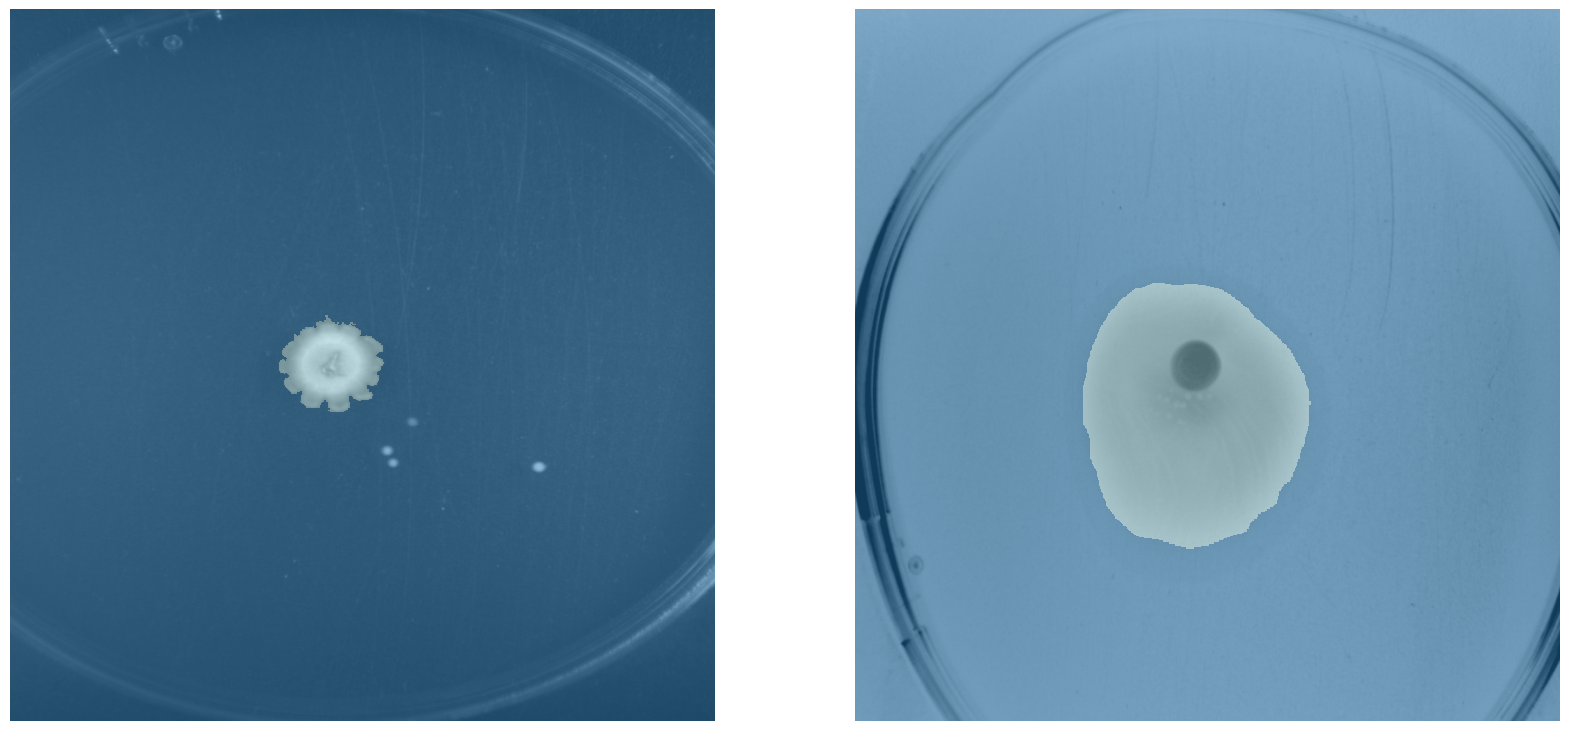

In [161]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(20,15))

###Definición de modelo

Ya podemos definir nuestro modelo y entrenarlo como hemos hecho en prácticas anteriores. Para ello vamos a crear un Learner mediante la función unet_learner a la cual le tenemos que proporcionar el DataLoader el backbone que vamos a utilizar (en este caso usaremos un modelo Resnet-18) y las métricas Dice y Jaccard que emplearemos para evaluar nuestro modelo.

In [162]:

learn = unet_learner(trainDLS,resnet18,metrics=[Dice(),JaccardCoeff()]).to_fp16()

Por último entrenamos nuestro modelo.

In [163]:
learn.fit_one_cycle(20,3e-3)

epoch,train_loss,valid_loss,dice,jaccard_coeff,time


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


OutOfMemoryError: CUDA out of memory. Tried to allocate 780.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 183.06 MiB is free. Process 1862 has 14.57 GiB memory in use. Of the allocated memory 12.40 GiB is allocated by PyTorch, and 2.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)